# MUSIC Super-resolution Microscopy

## Dependencies

In [277]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Program Parameters

In [446]:
class params:
    k     = 2       # Source number
    M     = 16      # Sensor array size (assuming square)
    T     = 200     # Snapshot number
    noise = 0.001   # Noise power
    width = 1       # Sensors are placed between [-width,width]
    sep   = 0.25    # Source inter-separation distance
    sig   = 0.3     # Gaussian kernel variance
    Q     = 32      # MUSIC 'Resolution'
p = params()

## Model

$$ f = Us$$ where $[U]_{m,k} = u(r_m - r_k) = \exp(-\frac{1}{2\sigma^2} (r_m - r_k)^2)$

## Gridless Generation of U Matrix (from True Source Points)

### From True Source Points

In [447]:
# Evenly spaced sources
w = np.linspace(-p.sep/2,p.sep/2,p.k)
w = np.vstack((w,w))

# Uniform Linear Array (ULA)
v1 = np.arange(0,p.M).reshape(-p.width,p.width) - (p.M-1)//2
# Normalize between -1 and 1
v1 = 2*v1/p.M

# Build the Gaussian (U matrix)

U = np.zeros((p.M**2,p.k))
for k in range(p.k):
    argx = v1 - w[0,k]
    argy = v1 - w[1,k]
    
    vx = np.exp(-(0.5/p.sig**2)*np.square(argx))
    vy = np.exp(-(0.5/p.sig**2)*np.square(argy))

    V = vx @ vy.T
    U[:,k] = V.reshape(-1)


### From Ground Truth Image

In [374]:
# Instead now create truth image
# x = np.zeros((p.Q,p.Q))
# x[p.Q//3,p.Q//3] = 1
# x[2*p.Q//3,2*p.Q//3] = 1

# # Create linear array locations
# v1 = np.arange(0,p.M).reshape(-1,1) - (p.M-1)//2

# # Our U matrix needs to be bigger now, including array points which might not even have a source.
# v2 = np.linspace(-3,3,p.Q)

# U = np.zeros((p.M**2,p.Q))
# for kx in range(p.Q):
#     for ky in range(p.Q):
#         argx = v1 - v2[kx]
#         argy = v1 - v2[ky]
    
#         vx = np.exp(-0.5*np.square(argx/p.sig))
#         vy = np.exp(-0.5*np.square(argy/p.sig))

#         V = vx @ vy.T
#         U[:,k] = V.reshape(-1)

# print(v2)
# plt.figure()
# plt.imshow(truth)
# plt.show()

## Measurement Data Generation 
### (True Source Positions)

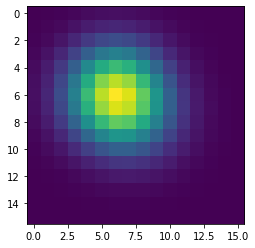

In [448]:
# Random Data
x = np.random.randn(p.k,p.T)
# Additive Gaussian Noise
n = p.noise * np.random.randn(p.M**2,p.T)
# Measurements
f = U @ x + n

plt.figure()
plt.imshow(np.abs(f[:,p.T//4]).reshape(p.M,p.M))

### (From Image)

In [347]:
# Vectorize Truth

# # Additive Gaussian Noise
# n = p.noise * np.random.randn(p.M**2,p.T)
# # Measurements
# f = U @ x + n

## Autocorrelation Estimates

In [449]:
R_ff = 1/p.T * f @ f.T

## Perform MUSIC

In [452]:
def MUSIC(R_ff, v1, L, sig, Q, width):
    # Perform Eigenvalue Decomposition on autocorrelation matrix
    U,_,_ = np.linalg.svd(R_ff)
    
    # Segment 
    V1 = U[:,:L]
    V2 = U[:,L:]
    
    # Build MUSIC high-resolution 'grid'
    v2 = np.linspace(-width,width,Q)
    
    # Build new matrix
    X = np.zeros((len(v1),len(v2)))
    X = X[...,:] + v1;
    X = X[:,...] - v2;
    
    A = np.exp(-0.5*np.square(X/sig))
    
    img = np.zeros((Q,1))
    
    for k in range(Q):
        NOISE = A[:,k].conj().T @ ( V2 @ V2.conj().T ) @ A[:,k]
        img[k] = 1/NOISE
    
    return img

def MUSIC2D(R_ff, v1, L, sig, Q, width):
    # SVD Decomposition on our autocorrelation matrix
    U,_,_ = np.linalg.svd(R_ff)
    
    # Segment in to signal and noise subspaces
    V1 = U[:,:L]
    V2 = U[:,L:]
    
    # Build MUSIC high-resolution source 'grid'
    v2 = np.linspace(-width,width,Q)
    
    A = np.zeros((len(v1)**2,Q**2))
    q = 0
    for kx in v2:
        for ky in v2:
            argx = v1 - kx
            argy = v1 - ky
            
            ax = np.exp(-0.5*np.square(argx/p.sig))
            ay = np.exp(-0.5*np.square(argy/p.sig))
            a  = ax @ ay.T
            A[:,q] = a.reshape(-1)
            q = q + 1
    
    img = np.zeros((Q**2,1))
    for q in range(Q**2):
        NOISE = A[:,q].conj().T @ ( V2 @ V2.conj().T ) @ A[:,q]
        img[q] = 1/NOISE
    
    return img.reshape(Q,Q)

In [453]:
img = MUSIC2D(R_ff,v1,p.k,p.sig,p.Q,p.width)

## Results

### Create Ground Truth Image

In [454]:
#https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx, a.flat[idx]


hr_axis = np.linspace(-1,1,p.Q)

# Assume diagonal sources, so grab just one cordinate
ww = w[0,:]

# Find points on high-resolution grid closest to truth
truth = np.zeros((p.Q,p.Q))
for k in range(p.k):
    indx,_ = find_nearest(hr_axis,ww[k])
    truth[indx,indx] = 1

### Create Diffraction Limited Image

In [455]:
dif_lim = np.mean(np.abs(f),axis=1).reshape(p.M,p.M)

### Create Plots

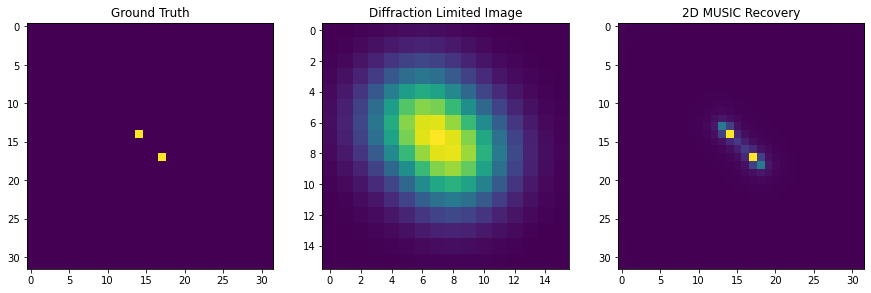

In [456]:
plt.figure(figsize=(15,10))
plt1 = plt.subplot(1,3,1)
plt.imshow(truth)
plt.title("Ground Truth")

plt2 = plt.subplot(1,3,2)
plt.imshow(dif_lim)
plt.title("Diffraction Limited Image")

plt3 = plt.subplot(1,3,3)
plt.imshow(img)
plt.title("2D MUSIC Recovery")

plt.show()